# Models

In [1]:
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import numpy
import math
import shap 
import tensorflow as tf
import matplotlib.pyplot as plt
import lightgbm as ltb

from functools import reduce
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectPercentile
from sklearn.metrics import confusion_matrix, classification_report, f1_score, auc, roc_curve, roc_auc_score, precision_score, recall_score, balanced_accuracy_score
from numpy.random import seed
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold, StratifiedKFold
seed(42)
tf.random.set_seed(38)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dense

numpy.set_printoptions(threshold=sys.maxsize)


2022-04-25 06:55:10.469388: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kali/.local/lib/python3.9/site-packages/cv2/../../lib64:
2022-04-25 06:55:10.469426: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# load pre porcessed data
df = pd.read_csv('data.csv')


#### Filterout the paper described patient set

In [3]:
# filter dataset as describe in paper
def get_filter_by_age_diabDur(df, age, diabDur):
    filter_patients = df[(df["AgeAtConsent"] >= age) & (df["diagDuration"] > diabDur)] 
#     filter_patients=filter_patients.drop_duplicates(subset="PtID",keep="first") 
    print(f'Number of patients whos age is {age}+ and diabetics duration greater than {diabDur}  is -> {filter_patients.PtID.size}')
    return filter_patients

df = get_filter_by_age_diabDur(df, 26, 2)

Number of patients whos age is 26+ and diabetics duration greater than 2  is -> 7155


In [4]:
# remove all unknown data

df.drop(df[df.DKAPast12mos == 2].index, inplace=True)


In [5]:
df1 = df.loc[(df['DKAPast12mos'] ==0 ) & (df['Pt_HospDKASinceDiag'] == 0)]
len(df1)

166

### for DKA events prediction pre processing


In [6]:
y_label = 'DKAPast12mos' 

In [7]:
# fill null value according to the other parameters

# fill with 0 - if data not available probably patient has not that medical condition
def fill_y_label(row):

    if(math.isnan(row['DKAPast12mos'])):
        if((row['NumDKAOccur'] >= 1) or (row['Pt_NumHospDKA']>=1)):
            row[y_label] = 0
        else:
            row[y_label] = 1
    return row


df = df.apply(fill_y_label, axis=1)


In [8]:
df['Pt_SmokeAmt'] = df['Pt_SmokeAmt'].replace({
    0: 0,1:0, 2:0, 3:0, 5:0, 6:0,
    4: 1
})

In [9]:
# get possible values in column including nan
def get_possible_vals_with_nan(df, colName):
    list_val =df[colName].unique().tolist()
    return list_val


# df['DKADiag'] = df['DKADiag'].replace({1.0: 0.0, 2.0:1.0, 3.0:1.0})
    
get_possible_vals_with_nan(df, 'DKADiag')


[2.0, 3.0, 0.0, 1.0]

In [10]:
pd.options.display.max_rows = 100

def get_missing_val_percentage(df):
    return (df.isnull().sum()* 100 / len(df))


missing_per = get_missing_val_percentage(df)

# get missing values < threshold feature name list
variables = df.columns
thresh = 40
variable = [ ]
var = []
for i in range(df.columns.shape[0]):
    if missing_per[i]<= thresh: #setting the threshold as 40%
        variable.append(variables[i])
    else :
        var.append(variables[i])
        
print("variables missing vals < threshold")     
print(variable)
print("Length: ", len(variable))

print()
print("variables missing vals > threshold")     
print(var)
print("Length: ", len(var))

variables missing vals < threshold
['PtID', 'Pt_InitTrt', 'Pt_SevHypoEver', 'Pt_HospDKASinceDiag', 'Pt_NumHospDKA', 'Pt_InsulinRecMethod', 'Pt_InsLev1PerDay', 'Pt_InsLev2PerDay', 'Pt_InsLant1PerDay', 'Pt_InsLant2PerDay', 'Pt_InsUnk', 'Pt_MealBolusMethod', 'Pt_InsCarbRat', 'Pt_InsCarbRatBrkfst', 'Pt_InsCarbRatLunch', 'Pt_InsCarbRatDinn', 'Pt_BolusDecCntCarb', 'Pt_BolusDaySnackFreq', 'Pt_BedtimeSnack', 'Pt_ChkBldSugPriBolus', 'Pt_MissInsDoseFreq', 'Pt_NumBolusDayUnk', 'Pt_InjLongActDayNotUsed', 'Pt_InjShortActDayNotUsed', 'Pt_LongActInsDayNotUsed', 'Pt_NumMeterCheckDay', 'Pt_DLoadHGMFreq', 'Pt_LogBook', 'Pt_ChkKetones', 'Pt_CGMUse', 'Pt_CGMStopUse', 'Pt_LastEyeExamPart', 'Pt_DiabRetTrtPart', 'Pt_LegBlind', 'Pt_HealthProfDiabEdu', 'Pt_GlutFreeDiet', 'Pt_HighBldPrTrt', 'Pt_Smoke', 'Pt_GenHealth', 'Pt_StressDiab', 'Pt_EduLevel', 'Pt_AnnualInc', 'Pt_HouseholdCnt', 'Pt_InsPriv', 'Pt_MaritalStatus', 'Pt_EmployStatus', 'Pt_RaceEth', 'HyperglyCritHbA1c', 'HyperglyCritRandGluc', 'ReqInsulinCrit',

In [11]:
# cols_to_del = ['Diab_dur_greater','HbA1C_SH', 'Pt_InsHumalog', 'Pt_InsNovolog', 'Pt_BolusDecCntCarb', 
#                'Pt_BolusBedtimeSnackFreq', 'Pt_InsPumpStartAge', 'Pt_PumpManuf', 'Pt_PumpModel',
#                'Pt_DaysLeavePumpIns', 'Pt_BasInsRateChgDay', 'Pt_NumBolusDay', 'Pt_ReturnPump', 
#                'Pt_InjMethod', 'Pt_InjLongActDay', 'Pt_InjShortActDay', 'Pt_LongActInsDay', 
#                'Pt_ShortActInsDay', 'Pt_PumpStopUse', 'Pt_HealthProfDiabEdu', 'Pt_SmokeAmt', 
#                'Pt_DaysWkEx', 'Pt_MenarcheAge', 'Pt_RegMenstCyc', 'Pt_IrregMenstCycReas',
#                'Pt_CurrPreg', 'Pt_MiscarriageNum', 'Pt_v3NumHospOthReas',
#                'HyperglyCritRandGluc', 'WeightDiag', 'NumDKAOccur', 'TannerNotDone', 'PumpTotBasIns',
#                'HGMNumDays', 'HGMTestCntAvg', 'HGMGlucMean', 'CGMGlucPctBelow70', 'CGMGlucPctBelow60', 
#                'PulseRate', 'InsCarbRatBrkfst', 'InsCarbRatLunch', 'InsCarbRatDinn', 'InsCarbRatDinnNotUsed', 
#                'CGMPctBelow55', 'CGMPctBelow80']

cols_to_del = ['Diab_dur_greater']


df.drop(cols_to_del, inplace=True, axis=1)
df.head(10)

,PtID,Pt_InitTrt,Pt_SevHypoEver,Pt_HospDKASinceDiag,Pt_NumHospDKA,Pt_InsulinRecMethod,Pt_InsLev1PerDay,Pt_InsLev2PerDay,Pt_InsLant1PerDay,Pt_InsLant2PerDay,...,CancPancr,CancPros,CancThyr,CancOth,Insulin_Glargine,Insulin_Lispro,Hydrochlorothiazide,Sertraline,Insulin_Aspart_Human,diagDuration
0,3963.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0876
4,12505.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.1684
7,26063.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0507
14,553.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.8549
15,13365.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.3915
20,15799.0,3.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.1739
24,15966.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0999
27,6426.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.1704
34,10659.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.9979
40,19861.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.6872


# Divide Dataset

In [12]:
df=df.drop('PtID', axis = 1)

In [13]:
# df=df.drop('PtID', axis = 1)

In [14]:
def corrX_orig(df, cut = 0.8) :
        
    # Get correlation matrix and upper triagle
    corr_mtx = df.corr().abs()
    avg_corr = corr_mtx.mean(axis = 1)
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool))
    
    drop = list()
    
    # For loop implements this pseudocode
    # For every cell in the upper triangle: 
        # If cell.value > 0.6: 
                # If mean(row_correlation) > mean(column_correlation):drop(column)
		# Else: drop(row)
        
    for row in range(len(up)-1):
        col_idx = row + 1
        for col in range (col_idx, len(up)):
            if(corr_mtx.iloc[row, col] > cut):
                if(avg_corr.iloc[row] > avg_corr.iloc[col]): 
                    drop.append(row)
                else: 
                    drop.append(col)
    
    drop_set = list(set(drop))
    dropcols_names = list(df.columns[[item for item in drop_set]])
    
    return(dropcols_names)

cols_to_drop = corrX_orig(df)


In [15]:

df.drop(['Lipoatrophy',
 'AgeAtConsent',
 'InsCarbRatDinn',
 'InsNovolog',
 'CGMGlucPctBelow60'], inplace=True, axis=1)
df.head(10)


,Pt_InitTrt,Pt_SevHypoEver,Pt_HospDKASinceDiag,Pt_NumHospDKA,Pt_InsulinRecMethod,Pt_InsLev1PerDay,Pt_InsLev2PerDay,Pt_InsLant1PerDay,Pt_InsLant2PerDay,Pt_InsUnk,...,CancPancr,CancPros,CancThyr,CancOth,Insulin_Glargine,Insulin_Lispro,Hydrochlorothiazide,Sertraline,Insulin_Aspart_Human,diagDuration
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0876
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.1684
7,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0507
14,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.8549
15,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.3915
20,3.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.1739
24,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0999
27,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.1704
34,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.9979
40,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.6872


In [16]:

def divide_data(df,label):
    Y = df[label]
    X = df.drop(label, axis=1)
    return X, Y

X, Y = divide_data(df, y_label)


In [17]:
Y.unique()

array([1., 0.])

# Feature Selection

In [18]:
shape = np.shape(X) 
feature = shape[1] 
n_classes = 2


In [19]:
seed(42)
tf.random.set_seed(38)
# Save original data set
original_X = X

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=123)


# if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)


In [20]:
len(Y_train == 0.0)
unique, counts = numpy.unique(Y_train.to_numpy(), return_counts=True)
print("Train - ", unique, counts)

unique_test, counts_test = numpy.unique(Y_test.to_numpy(), return_counts=True)
print("Test - ", unique_test, counts_test)


Train -  [0. 1.] [ 150 4478]
Test -  [0. 1.] [  50 1493]


# Imputations

<AxesSubplot:>

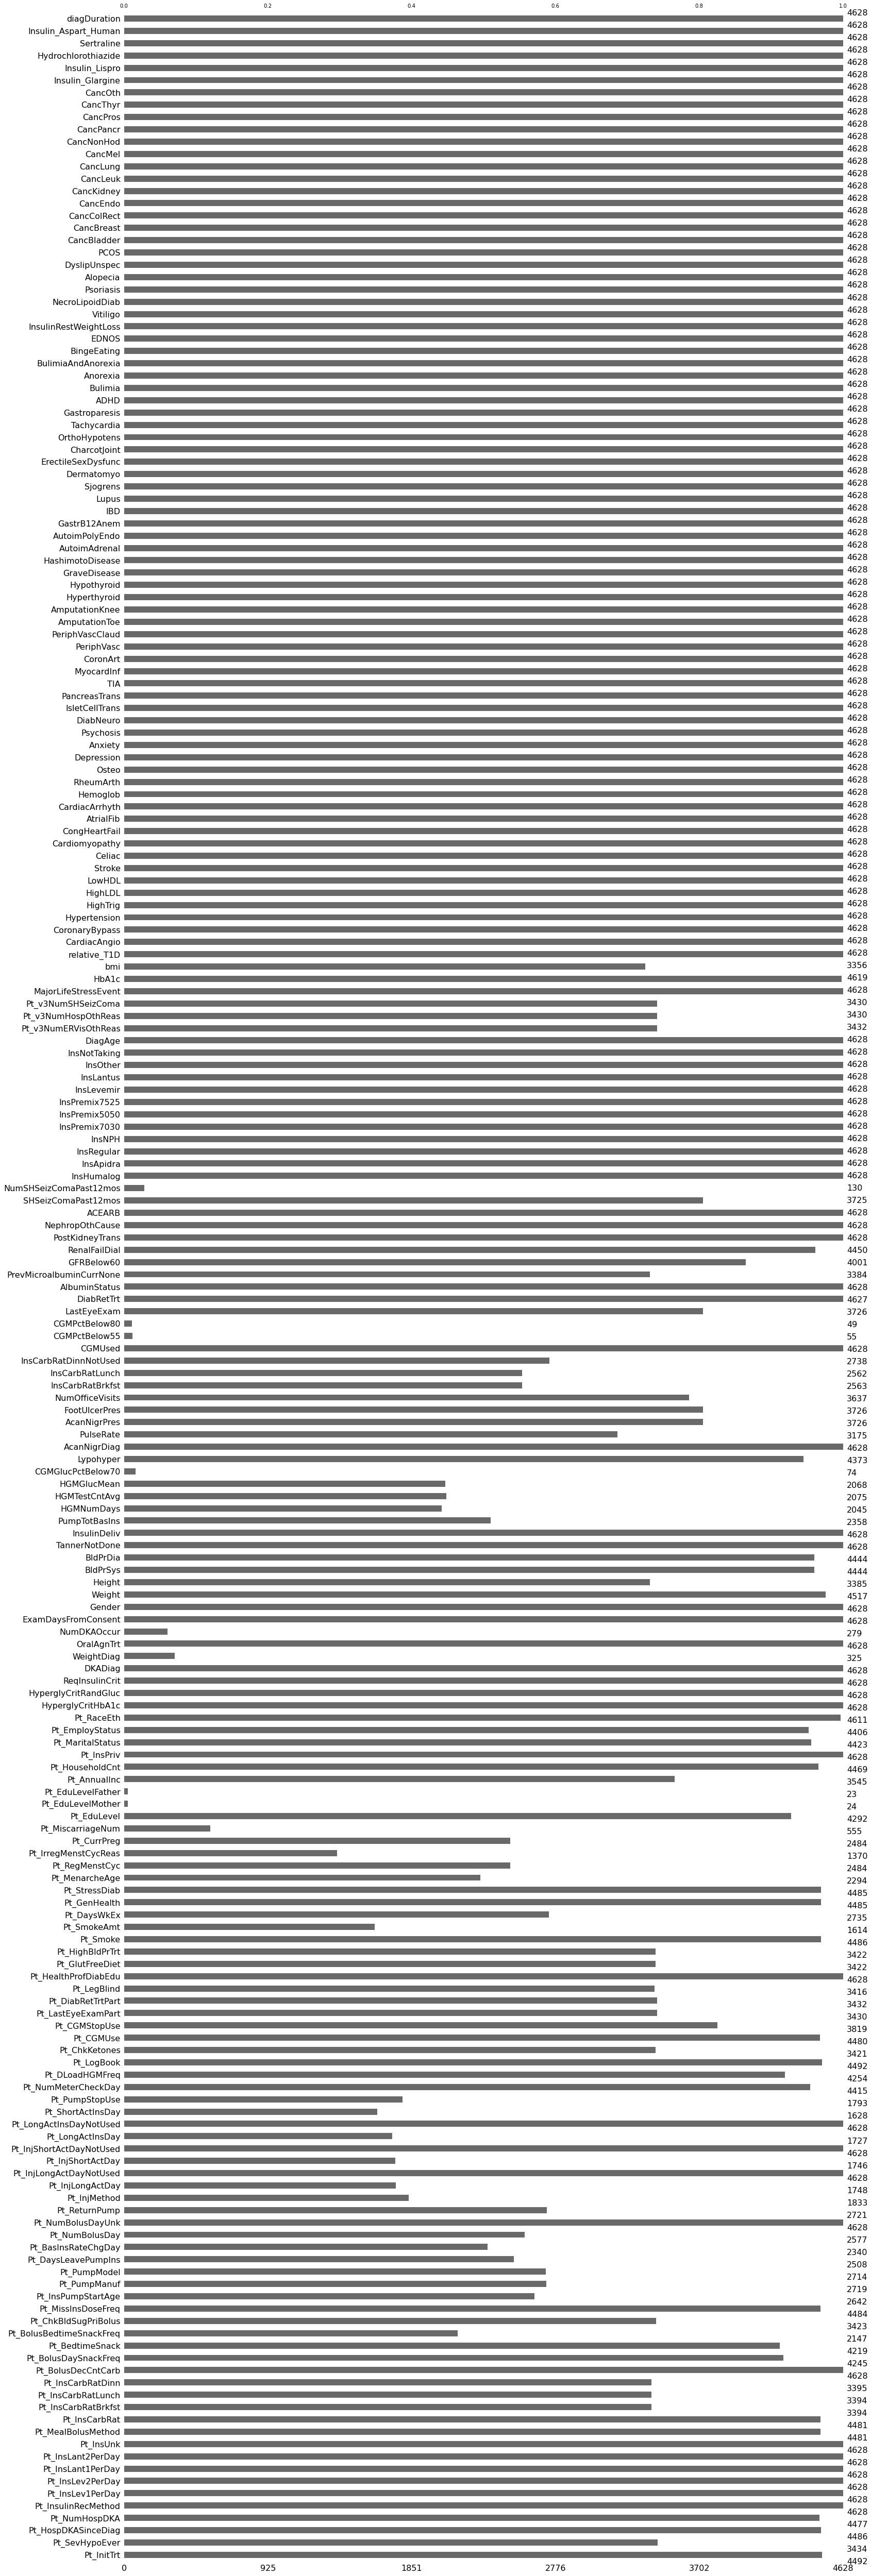

In [21]:
import missingno as msno
msno.bar(X_train)

### XGB with missing values

In [22]:
def plot_roc_curve(fpr, tpr, optimal_idx):
    plt.figure(figsize=(10,5))
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label='Best') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [23]:

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()


if('NumDKAOccur' in X_train.columns):
    X_train_copy = X_train_copy.drop(['NumDKAOccur'], axis=1)
    X_test_copy = X_test_copy.drop([ 'NumDKAOccur'], axis=1)
    
if('Pt_NumHospDKA' in X_train.columns):
    X_train_copy = X_train_copy.drop(['Pt_NumHospDKA'], axis=1)
    X_test_copy = X_test_copy.drop(['Pt_NumHospDKA'], axis=1)
    

In [24]:
# kf = KFold(n_splits= 3, shuffle=False)
train = X_train_copy.copy()
train[y_label] = Y_train.values



def cross_val_with_missing_val(model,n_splits=5):

    dfs = []
    acc_arr = []
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
    i = 1
    for train_index, test_index in kf.split(train, Y_train):
        X_train1 = train.iloc[train_index].loc[:, X_train_copy.columns]
        X_test1 = train.iloc[test_index].loc[:,X_train_copy.columns]
        y_train1 = train.iloc[train_index].loc[:,y_label]
        y_test1 = train.iloc[test_index].loc[:,y_label]

        
        #Train the model
        model.fit(X_train1, y_train1) #Training the model
        print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}, doublecheck: {model.score(X_test1,y_test1)}")
        acc_arr.append(accuracy_score(y_test1, model.predict(X_test1)))
        
        # how many occurances appear in the train set
        s_train = train.iloc[train_index].loc[:,y_label].value_counts()
        s_train.name = f"train {i}"
        s_test = train.iloc[test_index].loc[:,y_label].value_counts()
        s_test.name = f"test {i}"
        df = pd.concat([s_train, s_test], axis=1, sort=False)
        df["|"] = "|"
        dfs.append(df)

        i += 1

    print("Cross validation mean accuracy" , sum(acc_arr) / len(acc_arr))
    return model


Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.


Accuracy for the fold no. 1 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 2 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 3 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 4 on the test set: 0.9675675675675676, doublecheck: 0.9675675675675676
Accuracy for the fold no. 5 on the test set: 0.9675675675675676, doublecheck: 0.9675675675675676
Cross validation mean accuracy 0.967588582102621

 
 ===========   Train Dataset    =============
train ROC score 0.9426231948786661
Threshold value is: 0.9606588299149842


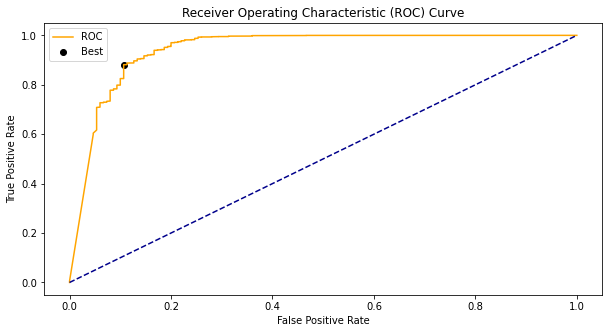

accuracy score:  88.18063958513397
              precision    recall  f1-score   support

         0.0       0.20      0.89      0.33       150
         1.0       1.00      0.88      0.94      4478

    accuracy                           0.88      4628
   macro avg       0.60      0.89      0.63      4628
weighted avg       0.97      0.88      0.92      4628



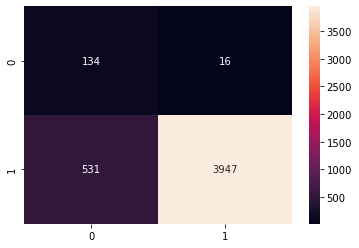

Accuracy of XGB on training set: 0.97


 ===========   Test Dataset    =============
Threshold value is: 0.974557738587774


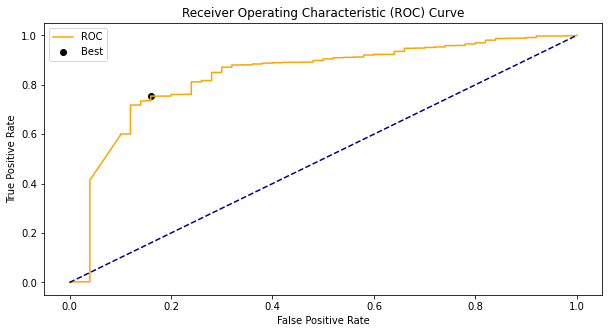

accuracy score:  75.69669475048607
              precision    recall  f1-score   support

         0.0       0.10      0.84      0.18        50
         1.0       0.99      0.75      0.86      1493

    accuracy                           0.76      1543
   macro avg       0.55      0.80      0.52      1543
weighted avg       0.96      0.76      0.84      1543



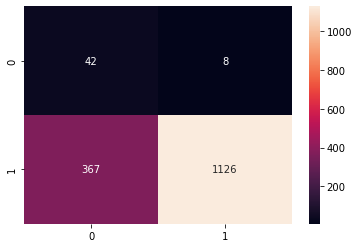

Accuracy of XGB classifier on test set: 0.97


 ===========   ROC    =============
roc_auc = 0.8373


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [0.84      0.7541862]
average accuracy:  0.7970931011386471
f1 0.7569669475048606


In [25]:
# xgboost - train with missing values
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier


model= HistGradientBoostingClassifier(loss= 'binary_crossentropy',
                                     learning_rate = 0.01,
                                     max_iter= 50,
                                     )          
# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()

train_acc = model.score(X_train_copy, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))



print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)



print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

test_acc = model.score(X_test_copy, Y_test)
print('Accuracy of XGB classifier on test set: {:.2f}'
     .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('average accuracy: ',  np.sum(acc)/2)

print('f1', metrics.f1_score(xgb_pred, Y_test, average = 'micro'))


In [ ]:
# feature importance graph of XGB
# feat_importances = pd.Series(model.feature_importances_, index=X_train_copy.columns[0:250])
# feat_importances.nlargest(20).plot(kind='barh')


In [ ]:
# xgboost - train with missing values

model=XGBClassifier(
        use_label_encoder=False,
        eta = 0.1,#eta between(0.01-0.2)
        max_depth = 5, #values between(3-10)
        max_delta_step = 10,
# #         scale_pos_weight = 0.4,
# #         n_jobs = 0,
        subsample = 0.5,#values between(0.5-1)
        colsample_bytree = 1,#values between(0.5-1)
        tree_method = "auto",
        process_type = "default",
        num_parallel_tree=7,
        objective='multi:softmax',
#         min_child_weight = 3,
        booster='gbtree',
        eval_metric = "mlogloss",
        num_class = n_classes
    )
                   
# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()

train_acc = model.score(X_train_copy, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))



print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)



print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

test_acc = model.score(X_test_copy, Y_test)
print('Accuracy of XGB classifier on test set: {:.2f}'
     .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('average accuracy: ',  np.sum(acc)/2)

print('f1', metrics.f1_score(xgb_pred, Y_test, average = 'micro'))



In [ ]:
# feature importance graph of XGB
feat_importances = pd.Series(model.feature_importances_, index=X_train_copy.columns[0:250])
feat_importances.nlargest(20).plot(kind='barh')

### LGBM Classifier with missing values

Accuracy for the fold no. 1 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 2 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 3 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 4 on the test set: 0.9675675675675676, doublecheck: 0.9675675675675676
Accuracy for the fold no. 5 on the test set: 0.9675675675675676, doublecheck: 0.9675675675675676
Cross validation mean accuracy 0.967588582102621

 
 ===========   Train Dataset    =============
train ROC score 0.9022137859163317
Threshold value is: 0.9833346681679037


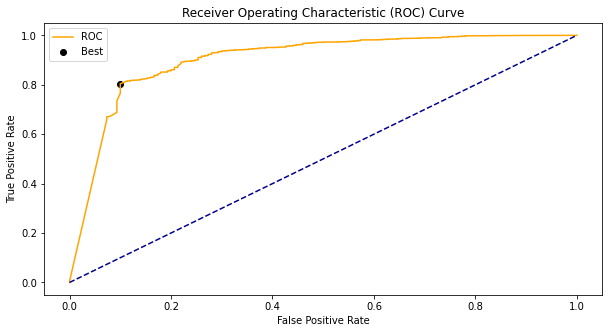

accuracy score:  80.7476231633535
              precision    recall  f1-score   support

         0.0       0.13      0.90      0.23       150
         1.0       1.00      0.80      0.89      4478

    accuracy                           0.81      4628
   macro avg       0.56      0.85      0.56      4628
weighted avg       0.97      0.81      0.87      4628



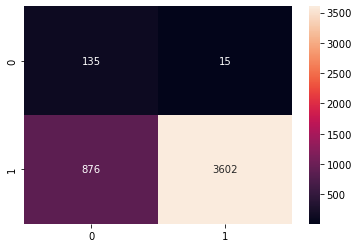

Accuracy of XGB on training set: 0.97


 ===========   Test Dataset    =============
Threshold value is: 0.9873488420747467


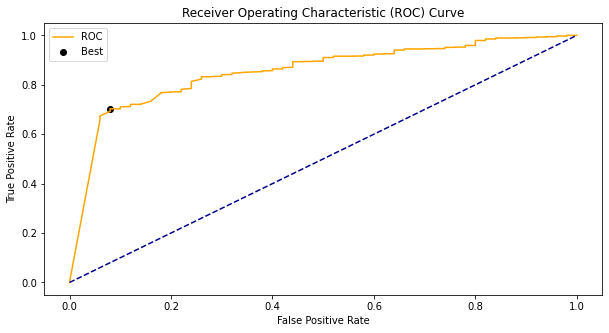

accuracy score:  70.96565132858069
              precision    recall  f1-score   support

         0.0       0.09      0.92      0.17        50
         1.0       1.00      0.70      0.82      1493

    accuracy                           0.71      1543
   macro avg       0.55      0.81      0.50      1543
weighted avg       0.97      0.71      0.80      1543



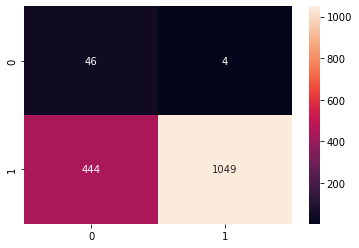

Accuracy of XGB classifier on test set: 0.97


 ===========   ROC    =============
roc_auc = 0.8537


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [0.92       0.70261219]
average accuracy:  0.8113060951105158
f1 0.709656513285807


In [26]:

# xgboost - train with missing values

model=ltb.LGBMClassifier(use_missing = True, 
                         learning_rate = 0.01, 
                         scale_pos_weight=7,
#                          is_balanced = False,
                         max_depth =4, random_state=0 )
                   
# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()

train_acc = model.score(X_train_copy, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))


print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

test_acc = model.score(X_test_copy, Y_test)
print('Accuracy of XGB classifier on test set: {:.2f}'
     .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('average accuracy: ',  np.sum(acc)/2)


print('f1', metrics.f1_score(xgb_pred, Y_test, average = 'micro'))

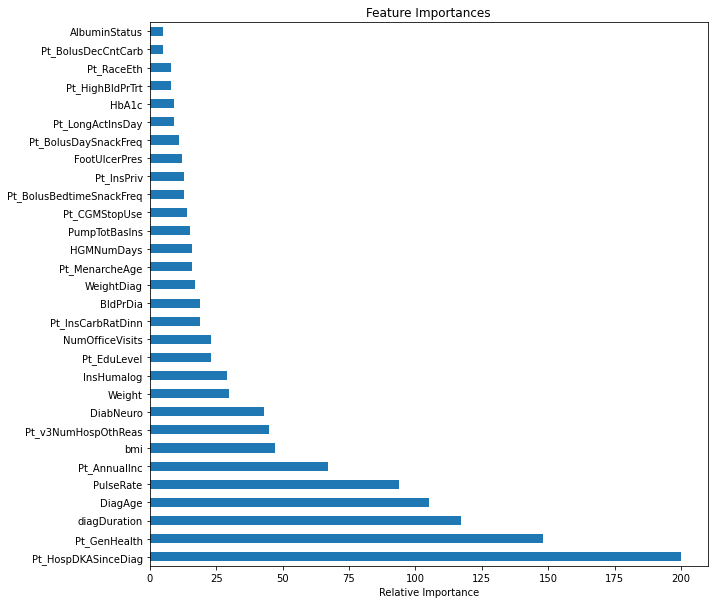

<Figure size 432x288 with 0 Axes>

In [27]:

# feature importance graph of XGB
plt.figure(figsize=(10,10))

plt.title('Feature Importances')
feat_importances = pd.Series(model.feature_importances_, index=X_train_copy.columns[0:250])
feat_importances.nlargest(30).plot(kind='barh')
plt.xlabel('Relative Importance')
plt.show()
plt.savefig('fiDKA.png')

In [28]:
# if is_male:
    
#     X_train.update(X_train[[
#                  'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
#                  'HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
#                  'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay'
#                  ]].fillna(0))

#     X_test.update(X_test[[
#                  'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
#                  'HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
#                  'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay'
#                  ]].fillna(0))
    
# else:
#     X_train.update(X_train[[
#              'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
#              'Pt_MiscarriageNum','HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
#              'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay'
#              ]].fillna(0))

#     X_test.update(X_test[[
#              'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
#              'Pt_MiscarriageNum','HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
#              'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay'
#              ]].fillna(0))
    

In [ ]:
# fill nan values in categorical dataset with frequent value

# tested wuth mean and median - results is lower than most_frequent
imputeX = SimpleImputer(missing_values=np.nan, strategy = "most_frequent")
# imputeX = KNNImputer(missing_values=np.nan, n_neighbors = 3, weights='distance')
# imputeX = IterativeImputer(max_iter=5, random_state=0)

X_train = imputeX.fit_transform(X_train)


In [ ]:
# test data imputation

Test = X_test.copy()
Test.loc[:,y_label] = Y_test

X_test = imputeX.transform(X_test)



# Scale data

In [ ]:
# Normalize numeric features
scaler = StandardScaler()
# scaler = MinMaxScaler()
select = {}
# select[0] = pd.DataFrame(scaler.fit_transform(X_traiposn))
# select[1] = Y_train
# select[2] = pd.DataFrame(scaler.transform(X_test))


select[0] = pd.DataFrame(X_train)
select[1] = Y_train
select[2] = pd.DataFrame(X_test)



## Feature Selection

In [ ]:
# TODO

# def select_features(select, feature):
#     selected = {}
#     fs = SelectKBest(score_func=mutual_info_classif, k=feature) # k=feature score_func SelectPercentile
#     selected[0] = fs.fit_transform(select[0], select[1])
#     selected[1] = fs.transform(select[2])
        
#     idx = fs.get_support(indices=True)
    
#     return selected, fs, idx



In [ ]:
#Selecting the Best important features according to Logistic Regression
# Give better performance than selectKBest 
def select_features(select, feature):
    selected = {}
#     fs = RFE(estimator=LogisticRegression(), n_features_to_select=feature, step = 1) #  step (the number of features eliminated each iteration) 
    fs = RFE(estimator=XGBClassifier(), n_features_to_select=feature, step = 5) #  step (the number of features eliminated each iteration) 
#     fs = RFE(estimator=RandomForestClassifier(), n_features_to_select=feature, step = 1) #  step (the number of features eliminated each iteration) 
    
    
    selected[0] = fs.fit_transform(select[0], select[1])
    selected[1] = fs.transform(select[2])
    
        
    idx = fs.get_support(indices=True)
    
    return selected, fs, idx


In [ ]:
# Feature selection
selected, fs, idx = select_features(select, feature)


In [ ]:
# Get columns to keep and create new dataframe with those only
from pprint import pprint
cols = fs.get_support(indices=True)
features_df_new = original_X.iloc[:,cols]
pprint(features_df_new.columns)
print(features_df_new.shape)

In [ ]:
X_train = pd.DataFrame(selected[0], columns = features_df_new.columns)
X_test = pd.DataFrame(selected[1], columns = features_df_new.columns)


In [ ]:

if('NumDKAOccur' in X_train.columns):
    X_train = X_train.drop(['NumDKAOccur'], axis=1)
    X_test = X_test.drop([ 'NumDKAOccur'], axis=1)
    
if('Pt_NumHospDKA' in X_train.columns):
    X_train = X_train.drop(['Pt_NumHospDKA'], axis=1)
    X_test = X_test.drop([ 'Pt_NumHospDKA'], axis=1)
    
# if('Pt_HospDKASinceDiag' in X_train.columns):
#     X_train = X_train.drop(['Pt_HospDKASinceDiag'], axis=1)
#     X_test = X_test.drop([ 'Pt_HospDKASinceDiag'], axis=1)


### Common functions

In [ ]:
# kf = KFold(n_splits= 3, shuffle=False)
train = X_train.copy()
train[y_label] = Y_train.values

def cross_val(model, n_splits=10):

    dfs = []
    acc_arr = []
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
    i = 1
    for train_index, test_index in kf.split(train, Y_train):
        X_train1 = train.iloc[train_index].loc[:, X_train.columns]
        X_test1 = train.iloc[test_index].loc[:,X_train.columns]
        y_train1 = train.iloc[train_index].loc[:,y_label]
        y_test1 = train.iloc[test_index].loc[:,y_label]

        #Train the model
        model.fit(X_train1, y_train1) #Training the model
        print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}, doublecheck: {model.score(X_test1,y_test1)}")
        acc_arr.append(accuracy_score(y_test1, model.predict(X_test1)))
        
        # how many occurances appear in the train set
        s_train = train.iloc[train_index].loc[:,y_label].value_counts()
        s_train.name = f"train {i}"
        s_test = train.iloc[test_index].loc[:,y_label].value_counts()
        s_test.name = f"test {i}"
        df = pd.concat([s_train, s_test], axis=1, sort=False)
        df["|"] = "|"
        dfs.append(df)

        i += 1
    print("Cross validation mean accuracy" , sum(acc_arr) / len(acc_arr))
    return model


In [ ]:
def optimal_thresh(model, X, Y):
    y_scores = model.predict_proba(X)[:,1]

    fpr, tpr, thresholds = roc_curve(Y, y_scores)
    print(roc_auc_score(Y, y_scores))
#     optimal_idx = np.argmax(sqrt(tpr * (1-fpr)))
    optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    plot_roc_curve(fpr, tpr, optimal_idx)
    return optimal_threshold

In [ ]:
def train_results(model, X_train, Y_train, pred_train):
    print("\n \n =====================   Train Dataset    ======================")

    print(accuracy_score(Y_train, pred_train)*100)

    confusion_matrix_train = pd.DataFrame(confusion_matrix(Y_train, pred_train))
    sns.heatmap(confusion_matrix_train, annot=True,fmt='g')
    print(classification_report(Y_train, pred_train))
    plt.show()
    
    train_acc = model.score(X_train, Y_train)
    print('Accuracy of on training set: {:.2f}'.format(train_acc))

def test_results(model, X_test, Y_test, pred):
    print("\n\n =====================   Test Dataset    =======================")

    print(accuracy_score(Y_test, pred)*100)

    confusion_matrix_model = confusion_matrix(Y_test, pred)
    sns.heatmap(confusion_matrix_model, annot=True,fmt='g')
    print(classification_report(Y_test, pred))
    plt.show()
    
    test_acc = model.score(X_test, Y_test)
    print('Accuracy of classifier on test set: {:.2f}'
         .format(test_acc))

def ROC_results(model, X_test, Y_test):
    print("\n\n =======================   Test-ROC    =========================")

    y_scores = model.predict_proba(X_test)
    score = roc_auc_score(Y_test, y_scores[:, 1])
    score = round(score,4)
    print(f'roc_auc = {score}')
    
def class_wise_test_accuracy(model, Y_test, pred):
    print("\n\n =======================   Class-wise test accuracy    =====================")
    confusion_matrix_model = confusion_matrix(Y_test, pred)
    acc = confusion_matrix_model.diagonal()/confusion_matrix_model.sum(axis=1)
    print('classwise accuracy [class 0, class 1]: ',(acc))
    print('average accuracy: ',( np.sum(acc)/2))
    
    print('f1', metrics.f1_score(pred, Y_test, average = 'micro'))   

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score

ltb_model = ltb.LGBMClassifier(use_missing = False, 
                         learning_rate = 0.01, 
                         scale_pos_weight=7,
                         max_depth =6, random_state=0 )
# ltb_model.fit(X_train, Y_train)
ltb_model = cross_val(ltb_model)

# pred=ltb_model.predict(X_test)
# pred_train=ltb_model.predict(X_train)

# find optimal threshold
optimal_threshold = optimal_thresh(ltb_model, X_test, Y_test)
pred = (ltb_model.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

optimal_threshold_train= optimal_thresh(ltb_model, X_train, Y_train)
pred_train = (ltb_model.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

# test and train results
train_results(ltb_model, X_train, Y_train, pred_train)
test_results(ltb_model, X_test, Y_test, pred)

# ROC
ROC_results(ltb_model, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(ltb_model, Y_test, pred)

print('f1', metrics.f1_score(pred, Y_test, average = 'micro'))

In [ ]:
feat_importances = pd.Series(ltb_model.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

In [ ]:
def draw_boundary(model, X, Y, thresh1, thresh2):
    
    prediction = (model.predict_proba(X)[:,1])
    
    X_axis= np.linspace(start = 0, stop = 1, num = len(prediction))
    d = pd.DataFrame(prediction, columns=['pre'])
    X_axis = pd.DataFrame(X_axis, columns=['x_axis_vals'])
    df = pd.concat([d.reset_index(drop=True), Y.reset_index(drop=True)], axis=1)
    df = pd.concat([df.reset_index(drop=True), X_axis.reset_index(drop=True)], axis=1)
    
    
    # plot histogram
    plt.figure(figsize=(15,7))
    plt.hist(prediction[Y==0], bins=50, label='Positive', alpha=1, color='b', density=True)
    plt.hist(prediction[Y==1], bins=50, label='Negative', alpha=0.5, color='r', density=True)
    plt.xlabel('Probability of being Positive Class', fontsize=10)
    plt.ylabel('Number of records in each bucket', fontsize=10)
    plt.legend(fontsize=10)
    plt.tick_params(axis='both', labelsize=10, pad=5)
    plt.show() 
    
    # plot scatter
    plt.figure(figsize=(16, 16))
    colormap = np.array(['k', 'y'])
    cs = df.DKAPast12mos.to_list()
    categories = np.array(cs).astype(int)
    plt.scatter(df.x_axis_vals, df.pre, s=100, c=colormap[categories], alpha=0.5)


    plt.axhline(y=thresh1, color='r')
    plt.axhline(y=thresh2, color = 'g')
    
    plt.axhspan(0.4, thresh1, facecolor='red', alpha=0.05)
    plt.axhspan(thresh1, thresh2, facecolor='yellow', alpha=0.05)
    plt.axhspan(thresh2, 1, facecolor='green', alpha=0.05)


    plt.xlabel('sample', fontsize=10)
    plt.ylabel('probability', fontsize=10)
    plt.show()


In [ ]:
patients_count = X_train.shape[0]

def get_optimal_threshold(model, X, full_cost, single_cost):
    threshold = 0.0
    no_patients = int(full_cost / single_cost)
    if no_patients > patients_count:
        threshold = 0.8
    else:
        prediction = (model.predict_proba(X)[:,1])
        prediction = np.sort(prediction)
        threshold = np.round(prediction[no_patients-1],2)
    return threshold
    
thresh1 = get_optimal_threshold(ltb_model, X_train, 8000, 200)
thresh2 = 0.875
draw_boundary(ltb_model, X_train, Y_train, thresh1, thresh2)


In [ ]:
def get_decision_boundaries(prob, thresh1, thresh2):
    label = ''
    if(prob < thresh1):
        label = 'high risk'
    elif(prob < thresh2):
        label = 'risk'
    else:
        label = 'low risk'
    return label


In [ ]:

row_to_show = 93
data_for_prediction = X_test.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired

data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

pred = (ltb_model.predict_proba(data_for_prediction_array)[:,1] >= optimal_threshold).astype(int)
print('predictoin', pred)
print('actial', Y_test.iloc[row_to_show])
ltb_model.predict_proba(data_for_prediction_array)

# Create object that can calculate shap values
explainer = shap.TreeExplainer(ltb_model)
# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction_array)
shap.initjs()
# The shap_values object above is a list with two arrays.
# The first array is the SHAP values for a negative outcome (have disease), 
# second array is the list of SHAP values for the positive outcome (don't have the disease).
# SHAP values for positive outcomes (pulling out shap_values[1]).
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction, link='logit')

In [ ]:
# compute SHAP values
explainer = shap.TreeExplainer(ltb_model, X_train)
shap_values = explainer(X_train)

In [ ]:
import matplotlib.pyplot as pl
shap.plots.beeswarm(shap_values, show=False)
shap.plots.beeswarm(shap_values[-1:], show=False, color="black")
pl.show()

In [ ]:
pred = ltb_model.predict_proba(X_train)[:,1] 

Y = pd.DataFrame(Y_train)
X_beeswarm = X_train.copy()
X_beeswarm['pred'] = pred
# X_beeswarm['Y'] = Y
X_beeswarm['Y'] = Y[y_label].to_list()

In [ ]:
idx = np.where((X_beeswarm['pred']>0.98) & (X_beeswarm['Y']== 0.0) )
print(idx)

idx2 = np.where((X_beeswarm['pred']<0.7) & (X_beeswarm['Y']== 0.0) )
print(idx2)

# negative case in positive side
idx3 = np.where((X_beeswarm['pred']<0.6) & (X_beeswarm['Y']== 1.0) )
print(idx3)

X_beeswarm.drop(['pred'], axis = 1)
X_beeswarm.drop(['Y'], axis = 1)

explainer = shap.Explainer(ltb_model, X_beeswarm)
shap_values = explainer(X_beeswarm)



Black = Predict negative , actual positive

Orange = Predict positive , actual positive

Green = Predict positive , actual negative

In [ ]:

shap.plots.beeswarm(shap_values, show=False, plot_size=[15,15], alpha = 1)
shap.plots.beeswarm(shap_values[80:81:], show=False, color="black", plot_size=[15,15])
shap.plots.beeswarm(shap_values[466:467:], show=False, color="black", plot_size=[15,15])
shap.plots.beeswarm(shap_values[578:579:], show=False, color="black", plot_size=[15,15])
shap.plots.beeswarm(shap_values[1670:1671:], show=False, color="black", plot_size=[15,15])

shap.plots.beeswarm(shap_values[50:51:], show=False, color="orange", plot_size=[15,15])
shap.plots.beeswarm(shap_values[27:28:], show=False, color="orange", plot_size=[15,15])
shap.plots.beeswarm(shap_values[237:238:], show=False, color="orange", plot_size=[15,15])
shap.plots.beeswarm(shap_values[254:255:], show=False, color="orange", plot_size=[15,15])
shap.plots.beeswarm(shap_values[310:311:], show=False, color="orange", plot_size=[15,15])

shap.plots.beeswarm(shap_values[1304:1305:], show=False, color="green", plot_size=[15,15])

plt.show()


Plot shows information-dense summary of how the top features in a dataset impact the model’s output. 

Each instance the given explanation is represented by a single dot on each feature fow. The x position of the dot is determined by the SHAP value of that feature, and dots “pile up” along each feature row to show density. 

Color is used to display the original value of a feature

In the plot HospitalDKA is the most important feature on average, and hospitalDKA = 1 Yes(red) people are more likely to have DKA.


HospitalDKA categories
No: 0,
Yes: 1,
Don\'t know: 2

### Adaboost model

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score

adaboost = AdaBoostClassifier(random_state=0,
                              learning_rate=0.1,
                              n_estimators=1000,
                              algorithm = "SAMME.R") #algorithm{‘SAMME’, ‘SAMME.R’}, default=’SAMME.R’

# adaboost.fit(X_train, Y_train)
adaboost = cross_val(adaboost)

# pred=adaboost.predict(X_test)
# pred_train=adaboost.predict(X_train)

# find optimal threshold
optimal_threshold = optimal_thresh(adaboost, X_test, Y_test)
pred = (adaboost.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

optimal_threshold_train= optimal_thresh(adaboost, X_train, Y_train)
pred_train = (adaboost.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

# test and train results
train_results(adaboost, X_train, Y_train, pred_train)
test_results(adaboost, X_test, Y_test, pred)

# ROC
ROC_results(adaboost, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(adaboost, Y_test, pred)


In [ ]:
feat_importances = pd.Series(adaboost.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

# Model - XGB

In [ ]:
# xgboost - train with missing values


xgb_impute=XGBClassifier(
        use_label_encoder=False,
        eta = 0.1,#eta between(0.01-0.2)
        max_depth = 4, #values between(3-10)
        max_delta_step = 10,
        subsample = 0.5,#values between(0.5-1)
        colsample_bytree = 1,#values between(0.5-1)
        tree_method = "auto",
        process_type = "default",
        num_parallel_tree=7,
        objective='multi:softmax',
        min_child_weight = 3,
        booster='gbtree',
        eval_metric = "mlogloss",
        num_class = n_classes
        )
        
# xgb_impute.fit(X_train,Y_train)
xgb_impute = cross_val(xgb_impute)

# xgb_pred=xgb_impute.predict(X_test)
# xgb_pred_train=xgb_impute.predict(X_train)


# find optimal threshold
optimal_threshold = optimal_thresh(xgb_impute, X_test, Y_test)
optimal_threshold_train= optimal_thresh(xgb_impute, X_train, Y_train)

xgb_pred = (xgb_impute.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
xgb_pred_train = (xgb_impute.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(xgb_impute, X_train, Y_train, xgb_pred_train)
test_results(xgb_impute, X_test, Y_test, xgb_pred)

# ROC
ROC_results(xgb_impute, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(xgb_impute, Y_test, xgb_pred)



In [ ]:
# feature importance graph of XGB
feat_importances = pd.Series(xgb_impute.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

In [ ]:
thresh1 = get_optimal_threshold(xgb_impute, X_train, 8000, 200)
thresh2 = 2.0
draw_boundary(xgb_impute, X_train, Y_train, thresh1, thresh2)

## Model 2 - Random forest

In [ ]:
#  random forest classifier

rf=RandomForestClassifier(max_depth=4,
                             n_estimators = feature,
                             criterion = 'gini', # {“gini”, “entropy”}, default=”gini”
                             class_weight = 'balanced', # {“balanced”, “balanced_subsample”}, dict or list of dicts, default=None
                             ccp_alpha=0.01,
                             random_state=0)

# rf.fit(X_train,Y_train)
rf = cross_val(rf)

# find optimal threshold
optimal_threshold = optimal_thresh(rf, X_test, Y_test)
optimal_threshold_train= optimal_thresh(rf, X_train, Y_train)

# pred=rf.predict(X_test)
pred = (rf.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

# pred_train=rf.predict(X_train)
pred_train = (rf.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(rf, X_train, Y_train, pred_train)
test_results(rf, X_test, Y_test, pred)

# ROC
ROC_results(rf, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(rf, Y_test, pred)

In [ ]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 3 LogisticRegression

In [ ]:
#penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’
logreg = LogisticRegression(
    penalty='l2',
    tol = 5e-4,
    C=1,
    l1_ratio = 10,
    class_weight='balanced',  # balanced
    random_state=0,
    solver = 'saga' # saga, sag
)

# logreg.fit(X_train, Y_train)
logreg = cross_val(logreg)

# pred=logreg.predict(X_test)
# pred_train=logreg.predict(X_train)

# find optimal threshold
optimal_threshold = optimal_thresh(logreg, X_test, Y_test)
optimal_threshold_train= optimal_thresh(logreg, X_train, Y_train)

pred = (logreg.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (logreg.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(logreg, X_train, Y_train, pred_train)
test_results(logreg, X_test, Y_test, pred)

# ROC
ROC_results(logreg, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(logreg, Y_test, pred)

In [ ]:

feat_importances = pd.Series(logreg.coef_[0], index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 6 - Linear Discriminant Analysis

In [ ]:

lda = LinearDiscriminantAnalysis(
    solver = 'eigen', # solver{‘svd’, ‘lsqr’, ‘eigen’}, default=’svd’
    shrinkage= 'auto', #shrinkage‘auto’ or float, default=None
    n_components = 1,
    tol = 1e-3                       
)
# lda.fit(X_train, Y_train)
lda = cross_val(lda)

# pred=lda.predict(X_test)
# pred_train=lda.predict(X_train)

# find optimal threshold
optimal_threshold = optimal_thresh(lda, X_test, Y_test)
optimal_threshold_train= optimal_thresh(lda, X_train, Y_train)

pred = (lda.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (lda.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(lda, X_train, Y_train, pred_train)
test_results(lda, X_test, Y_test, pred)

# ROC
ROC_results(lda, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(lda, Y_test, pred)


In [ ]:
feat_importances = pd.Series(lda.coef_[0], index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')


## Model 7- Gaussian Naive Bayes

In [ ]:

gnb = GaussianNB(priors=None, var_smoothing=1.0)
gnb = cross_val(gnb)

gnb.fit(X_train, Y_train)
      
# pred=gnb.predict(X_test)
# pred_train=gnb.predict(X_train)

# find optimal threshold
optimal_threshold = optimal_thresh(gnb, X_test, Y_test)
optimal_threshold_train= optimal_thresh(gnb, X_train, Y_train)

pred = (gnb.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (gnb.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(gnb, X_train, Y_train, pred_train)
test_results(gnb, X_test, Y_test, pred)

# ROC
ROC_results(gnb, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(gnb, Y_test, pred)


In [ ]:
from sklearn.inspection import permutation_importance
imps = permutation_importance(gnb, X_test, Y_test)

feat_importances = pd.Series(imps.importances_mean, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

In [ ]:
d = pd.DataFrame(Y_test).head(100)
# s = d[d.DKAPast12mos == 0.0]
# for index, row in d.iterrows():
#     if row.DKAPast12mos == 0.0:
#         print(index)
d      

## SHAP Values

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


my_model = RandomForestClassifier(random_state=0).fit(X_train, Y_train)

row_to_show = 93
data_for_prediction = X_test.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

pred = my_model.predict(data_for_prediction_array)
print('predictoin', pred)
print('actial', Y_test.iloc[row_to_show])
my_model.predict_proba(data_for_prediction_array)

import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)


shap.initjs()

# The shap_values object above is a list with two arrays.
# The first array is the SHAP values for a negative outcome (have disease), 
# second array is the list of SHAP values for the positive outcome (don't have the disease).
# SHAP values for positive outcomes (pulling out shap_values[1]).
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction)

NOTE: How do you interpret shap

We predicted 0.7, whereas the base_value is 0.4979. Feature values causing increased predictions are in pink, and their visual size shows the magnitude of the feature's effect. Feature values decreasing the prediction are in blue. The biggest impact comes from weight being -0.9503. Though the pt_hospDKASinceDiag value has a meaningful effect decreasing the prediction.